In [68]:
import os
base_dir = 'C:\Users\Ben\Documents\GitHub\expression_broad_data'
os.chdir(base_dir) 
from core import expression_plots 
from core import io_library 
# from IPython.core.debugger import Tracer
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import csv
import scipy.cluster.hierarchy as sch
from collections import Counter, defaultdict
#from sklearn.cluster import AgglomerativeClustering


In [41]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#Writes Metadata file for KL and SC experiments
#Only needs to be done once

kl_PKA_metadata = [['sample_name', 'strain','NMPP1'],
                      ['AS1_minus', 'AS','minus'],
                      ['AS1_plus', 'AS', 'plus'],
                      ['AS2_minus', 'AS','minus'],
                      ['AS2_plus', 'AS', 'plus'],
                      ['WT_minus', 'WT', 'minus'],
                      ['WT_plus', 'WT', 'plus']]

with open(base_dir + "\expression_data\kl_PKA_as_20160824\kl_NMPP1_metadata.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(kl_PKA_metadata)
    
sc_PKA_metadata = [['sample_name', 'strain','NMPP1'],
                      ['SC_AS_plus','AS', 'plus'],
                      ['SC_WT_minus','WT', 'minus'],
                      ['SC_WT_plus','WT', 'plus']]

with open(base_dir + "\expression_data\SCer_NMPP1_RNA_Seq\sc_NMPP1_metadata.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(sc_PKA_metadata)

#This data and the raw data was then converted to rlog data and DEseq data in R. 

In [3]:
# Goal 1 Plot DE Seq (and rlog and count normalized fold change) alongside KL Expression data from regev. See how much overlap the 
#PKA inhibition transcriptome has with the ESR as determined from the REGEV data.  

#Import DE Seq Data, [later rlog and raw count data]
#convert kl_genename to standard format.  
kl_nmpp1_DESEQ = pd.read_csv(base_dir + "\expression_data\kl_PKA_as_20160824\DESEQ_KLac_ASmin_ASplus.csv")
rename_dict = {kl_nmpp1_DESEQ.columns[0]:'kl_genename_GFF'}
kl_nmpp1_DESEQ.rename(columns = rename_dict, inplace = True)

#Convert kl_genename to standard format. 
kl_genename = []
for gene in kl_nmpp1_DESEQ['kl_genename_GFF']:
    if gene[0:5]=='KLLA0':
        new_gene = gene.split('_')[0]+gene.split('_')[1]
    else: 
        new_gene = gene
    kl_genename.append(new_gene)
kl_nmpp1_DESEQ['orf_name'] = kl_genename
kl_nmpp1_DESEQ
kl_nmpp1_lfc = kl_nmpp1_DESEQ[['orf_name', 'log2FoldChange']]
kl_nmpp1_lfc.rename(index=str, columns={"log2FoldChange": "PKA(AS)+1NMPP1"}, inplace = True)

C:\Users\Ben\AppData\Local\Enthought\Canopy\User\lib\site-packages\pandas\core\frame.py:2748: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [91]:
#Reload KL Data - had to update growth data file after noticing an error
#only need to do this once
species_list = ['Kluyveromyces lactis', 'Saccharomyces cerevisiae']
fname_out_bases = ['KLac', 'SCer']
base_dir = 'C:\Users\Ben\Documents\GitHub\expression_broad_data'

io_library.make_data_tables(species_list,fname_out_bases, base_dir)

C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\raw_exp\KLac_raw_exp.csv saved


core\io_library.py:200: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  expdata = expdata.sort()


All ID's match between experiment data and orf lookup table. Species = Kluyveromyces lactis, Experiment Type = Growth
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE36253_Growth\KLac_growth.csv saved
All ID's match between experiment data and orf lookup table. Species = Kluyveromyces lactis, Experiment Type = Stress
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE38478_Stress\KLac_stress.csv saved
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\raw_exp\SCer_raw_exp.csv saved
All ID's match between experiment data and orf lookup table. Species = Saccharomyces cerevisiae, Experiment Type = Growth
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE36253_Growth\SCer_growth.csv saved
All ID's match between experiment data and orf lookup table. Species = Saccharomyces cerevisiae, Experiment Type = Stress
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE38478_Stress\SCer_stress.csv sav

In [4]:
#Import KL ESR data

# This is the regev raw expression
#   1) It might be interesting to plot it v.s. the RNA seq level data (but counts is not gene expression)
#   2) It would be good to integrate the data into the big dataframe
# #Load raw expression data
# species = 'KLac'
# fname = os.path.normpath(base_dir + "\expression_data\\raw_exp\\"  + species + '_raw_exp.csv')
# raw_exp = pd.read_csv(fname, index_col = 'orf_name')
# print fname + ' raw expression dataset loaded'
# #extract mean expression only
# mean_gene_expression = raw_exp['Mean']
# mean_gene_expression.name = 'mean_gene_expression'

#Load data for microarrays
species = 'KLac'

fname = os.path.normpath(base_dir + "\expression_data\\GSE36253_Growth\\"  + species + '_growth.csv' )
growth_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print fname + ' growth microarray dataset loaded'

#group by conditions and take mean
growth_replicate_groups = growth_exp.groupby(axis = 1, level = 'conditions')
growth_exp_avg = growth_replicate_groups.aggregate(np.mean)

fname = os.path.normpath(base_dir + "\expression_data\\GSE38478_Stress\\"  + species + '_stress.csv' )
stress_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print fname + ' stress microarray dataset loaded'

#group by condition and take mean
stress_replicate_groups = stress_exp.groupby(axis = 1, level = 'conditions')
stress_exp_avg = stress_replicate_groups.aggregate(np.mean)

#combine growth and stress average expression datasets. 
if False in stress_exp_avg.index==growth_exp_avg.index:
    print "Error: ID mismatch between condition data. Species = {}".format(species)
condition_arrays = pd.concat([growth_exp_avg,stress_exp_avg], axis = 1)

#gets rid of ID index
condition_arrays.reset_index(level=0, inplace=True)



C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE36253_Growth\KLac_growth.csv growth microarray dataset loaded
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE38478_Stress\KLac_stress.csv stress microarray dataset loaded


In [5]:
#Join Regev data to Log fold change from KL PKA inhibition experiment

kl_stress_nmpp1_data = kl_nmpp1_lfc.join(condition_arrays, on = 'orf_name') 
kl_stress_nmpp1_data.drop('ID', axis=1, inplace=True)
kl_stress_nmpp1_data.set_index('orf_name',inplace = True)

<IPython.core.display.Javascript object>


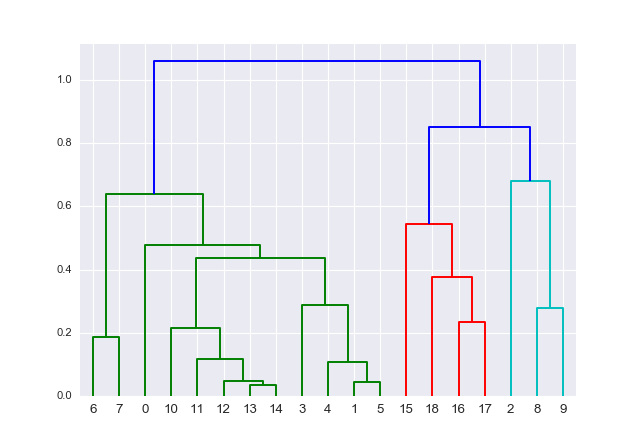

[6, 7, 0, 10, 11, 12, 13, 14, 3, 4, 1, 5, 15, 18, 16, 17, 2, 8, 9]
[0, 3, 4, 1, 5, 11, 12, 13, 14, 6, 7, 18, 17, 16, 15, 8, 9, 2]


<IPython.core.display.Javascript object>


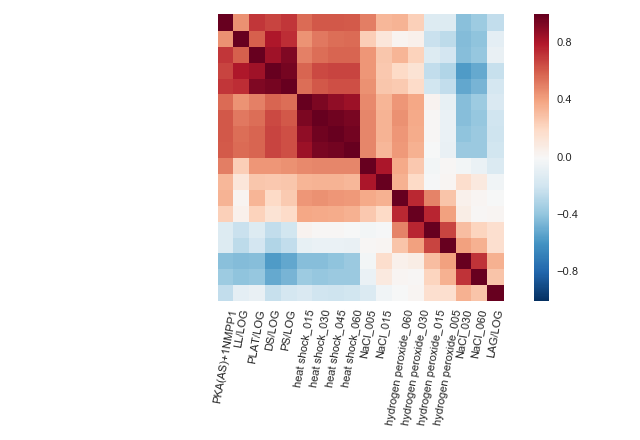

In [6]:
#Correlation heatmap with all conditions v.s. PKA inhibition. 

#First do heirarchical clustering of conditions, then reorder matrix. 
kl_stress_nmpp1_data_nanrm = kl_stress_nmpp1_data.fillna(0.0)
kl_stress_nmpp1_data_transpose = kl_stress_nmpp1_data_nanrm.as_matrix().transpose()
col_cluster = sch.linkage(kl_stress_nmpp1_data_transpose, method='average', metric = 'correlation')
col_dend = sch.dendrogram(col_cluster)
col_ind_reorder = col_dend['leaves']
#new columns look almost right but need to flip the tree around.  
print col_ind_reorder
col_ind_reorder_pretty = [0,3,4,1,5,11,12,13,14,6,7,18,17,16,15,8,9,2]
print col_ind_reorder_pretty

# col_ind_reorder_branch_flip ={16 : 19, 19: 18, 18:16}
# col_ind_reorder_pretty = col_ind_reorder[:]  #Need to use slice because otherwise the two lists are linked.  This makes a copy
# for key in col_ind_reorder_branch_flip.keys():
#     ind_ind = col_ind_reorder.index(key)
#     col_ind_reorder_pretty[ind_ind] = col_ind_reorder_branch_flip[key]

old_cols = kl_stress_nmpp1_data.columns.tolist()
new_cols = [old_cols[ind] for ind in col_ind_reorder_pretty]



kl_stress_nmpp1_data_col_reorder = kl_stress_nmpp1_data[new_cols]

#Plot correlation Matrix
#corr = kl_stress_nmpp1_data.corr()
corr = kl_stress_nmpp1_data_col_reorder.corr()
fig2, ax = plt.subplots()
ax = sns.heatmap(corr)
ax.tick_params(axis='y',labelleft = 'off')
plt.setp(ax.get_xticklabels(), rotation = 80)
plt.tight_layout()
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\KL_corr.png')
#Clean up labels


In [144]:
df = 
df

,PKA(AS)+1NMPP1,LL/LOG,PLAT/LOG,DS/LOG,PS/LOG,heat shock_015,heat shock_030,heat shock_045,heat shock_060,NaCl_005,NaCl_015,hydrogen peroxide_060,hydrogen peroxide_030,hydrogen peroxide_015,hydrogen peroxide_005,NaCl_030,NaCl_060,LAG/LOG
orf_name,,,,,,,,,,,,,,,,,,
KLLA0F00352g,-5.000507,-1.042415,-1.420822,0.143600,-0.316706,NaN,-1.033987,-0.034364,-0.537111,-0.275109,-0.089419,-0.866017,-0.538163,-1.291528,-0.956721,0.304519,-0.328510,0.061575
KLLA0F00440g,3.092199,-4.265947,-2.533781,-2.209142,-2.195627,1.896945,0.435864,0.272772,0.115559,0.867008,0.947656,-1.719272,-0.771807,-0.507872,-0.321088,-0.539165,0.085199,-0.397891
KLLA0F00506g,2.551387,1.196702,0.890221,2.091250,1.386570,2.937749,3.136820,2.934432,2.713650,0.065838,-0.048053,0.069621,0.346136,0.270469,-0.077988,-0.957547,-0.551824,-2.879777
KLLA0F00682g,5.239148,-0.497322,7.518427,3.223110,5.772992,0.219816,0.604317,0.153888,1.630100,0.844107,0.477453,3.727930,2.519909,-0.116220,-0.001754,0.313240,-0.706567,3.258894
KLLA0F01034g,-2.789732,-0.316229,-2.292776,-1.615135,-1.789795,-2.021910,-2.262522,-2.145620,-2.072701,-0.105708,-0.078447,-0.328427,-0.111526,0.393168,0.330744,0.180026,0.024063,0.039181
KLLA0F01078g,-2.802533,-0.591884,-3.222076,-2.024987,-2.782553,-0.949681,-1.137924,-1.268532,-1.380624,-0.188954,-0.246027,0.487071,0.245583,0.334686,0.340808,0.350190,0.145070,1.403754
KLLA0F01122g,-6.751808,-1.242733,-2.925650,-3.443900,-3.362186,-4.006057,-4.419628,-3.754417,-3.159847,-0.985615,-1.059911,-0.316506,0.360601,0.997917,0.756649,0.934302,0.361651,1.250472
KLLA0F01595g,2.463118,0.296239,-2.848482,-0.330596,-1.269570,0.284074,-0.606791,-0.756163,-0.076242,0.309259,0.155115,0.199956,0.645048,-0.614433,-0.881148,-0.159641,-0.395828,-4.897851
KLLA0F02321g,-4.589608,-0.884024,-4.034323,-3.777905,-4.139599,-3.261996,-3.736882,-3.159921,-2.738764,-0.765212,-0.784569,-0.760384,0.015357,0.999748,0.681183,0.448875,0.325615,1.276489


In [15]:
#row_dend = sch.dendrogram(row_cluster, no_plot = True, truncate_mode = 'lastp')


3888

In [43]:
kl_stress_nmpp1_data_filt_reorder.as_matrix()

array([[ 2.04438769,  0.77706463,  2.84088395, ..., -1.05463471,
        -0.0397089 ,  1.14340018],
       [ 1.68813019, -0.6628994 ,  0.18090213, ...,  0.03229774,
        -0.17414054,  1.10931428],
       [ 0.35362892,  0.01824153,  2.77120843, ...,  1.90951896,
         0.63157006,  3.01630304],
       ..., 
       [ 0.26616323,  0.15494375,  1.80090837, ..., -0.20952015,
        -0.07675202,  1.07294947],
       [-0.75195632, -0.47288606, -1.16335086, ...,  0.14598947,
         0.03919666, -2.7541805 ],
       [-0.47343076, -0.13045732, -1.86492586, ..., -0.07042222,
         0.12217958, -2.16885289]])

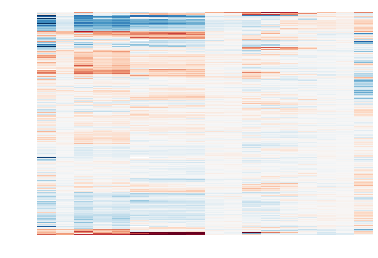

In [52]:
#Heirarchical cluster of genes with columns ordered as above to visualise ESR genes. 

kl_stress_nmpp1_data_filt = kl_stress_nmpp1_data_col_reorder.dropna(thresh=(len(kl_stress_nmpp1_data_col_reorder.columns)-1))
kl_stress_data = kl_stress_nmpp1_data_filt.drop('PKA(AS)+1NMPP1', axis = 1)

kl_stress_data_nafill = kl_stress_data.fillna(0.0)
kl_stress_data_mat = kl_stress_data_nafill.as_matrix()

#fig3, ax_cm = plt.subplots()
#ax_cm = sns.clustermap(kl_stress_data_col_reorder_nafill,colcluster = False)
#ax_cm.ax_heatmap.tick_params(labelleft = 'off')

row_cluster = sch.linkage(kl_stress_data_mat, method='average')
row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = kl_stress_nmpp1_data_filt.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

kl_stress_nmpp1_data_filt_reorder = kl_stress_nmpp1_data_filt.reindex(new_rows)

fig3, ax3 = plt.subplots()
#ax3= sns.heatmap(kl_stress_nmpp1_data_filt_reorder)
# ax3 = plt.imshow(kl_stress_nmpp1_data_filt_reorder.as_matrix(), cmap='RdBu', vmin=z_min, vmax=z_max,
#            extent=[x.min(), x.max(), y.min(), y.max()],
#            interpolation='nearest', origin='lower')
ax3 = plt.imshow(-kl_stress_nmpp1_data_filt_reorder.as_matrix(), interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin = -6, vmax = 6)
plt.axis('off')
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\KL_genes.png')


C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE36253_Growth\SCer_growth.csv growth microarray dataset loaded
C:\Users\Ben\Documents\GitHub\expression_broad_data\expression_data\GSE38478_Stress\SCer_stress.csv stress microarray dataset loaded


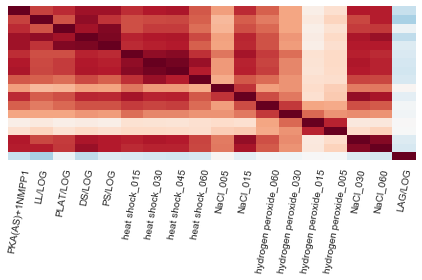

In [53]:
#Using same condition ordering as in KL dataset, look at SCer condition clustering. 

#Import SCer NMPP1 microarray data from O'shea microarrays
desired_conditions = [('No 1-NMPP1 0 min','GSM812516'), ('3uM 1-NMPP1 40 min','GSM812520')]   
data_dir = base_dir + '\expression_data\GSE32703_NMPP1_SC\\' 
GEO_accession = 'GSE32703'
oshea_SC_PKA_data = io_library.parse_data_series_matrix_SC(desired_conditions, data_dir, GEO_accession)
oshea_SC_PKA_data['PKA(AS)+1NMPP1'] = oshea_SC_PKA_data.iloc[:,1].sub(oshea_SC_PKA_data.iloc[:,0])


#Import Regev data for SCer
#Load data for microarrays
species = 'SCer'

fname = os.path.normpath(base_dir + "\expression_data\\GSE36253_Growth\\"  + species + '_growth.csv' )
growth_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print fname + ' growth microarray dataset loaded'

#group by conditions and take mean
growth_replicate_groups = growth_exp.groupby(axis = 1, level = 'conditions')
growth_exp_avg = growth_replicate_groups.aggregate(np.mean)

fname = os.path.normpath(base_dir + "\expression_data\\GSE38478_Stress\\"  + species + '_stress.csv' )
stress_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print fname + ' stress microarray dataset loaded'

#group by condition and take mean
stress_replicate_groups = stress_exp.groupby(axis = 1, level = 'conditions')
stress_exp_avg = stress_replicate_groups.aggregate(np.mean)

#combine growth and stress average expression datasets. 
if False in stress_exp_avg.index==growth_exp_avg.index:
    print "Error: ID mismatch between condition data. Species = {}".format(species)
condition_arrays_SC = pd.concat([growth_exp_avg,stress_exp_avg], axis = 1)

#gets rid of ID index
condition_arrays_SC.reset_index(level=0, inplace=True)


#Merge NMPP1 and Condition Data
sc_stress_nmpp1_data = pd.merge(oshea_SC_PKA_data, condition_arrays_SC, how='inner', left_index=True, right_index=True)
sc_stress_nmpp1_data.drop(['ID', 'No 1-NMPP1 0 min', '3uM 1-NMPP1 40 min'], axis=1, inplace=True)
sc_stress_nmpp1_data
#sc_stress_nmpp1_data.set_index('orf_name',inplace = True)

#Reorder columns 
old_cols = sc_stress_nmpp1_data.columns.tolist()
new_cols = [old_cols[ind] for ind in col_ind_reorder_pretty]

sc_stress_nmpp1_data_col_reorder = sc_stress_nmpp1_data[new_cols]

#Plot correlation Matrix
corr = sc_stress_nmpp1_data_col_reorder.corr()
fig2, ax = plt.subplots()
ax = sns.heatmap(corr, cbar = False)
ax.tick_params(axis='y',labelleft = 'off')
plt.setp(ax.get_xticklabels(), rotation = 80)
plt.tight_layout()
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\SC_corr.png')

#Make Correlation plot


#Cluster genes and plot

6212
6184
clustering
plotting


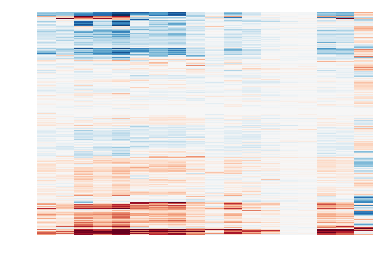

In [120]:
#Heirarchical cluster of genes with columns ordered as above to visualise ESR genes.

#Filter out columns that have mostly NA values. 
sc_stress_nmpp1_data_filt = sc_stress_nmpp1_data_col_reorder.dropna(thresh=(len(sc_stress_nmpp1_data_col_reorder.columns)-1))

#Combine rows that have duplicate values. 
gene_names = sc_stress_nmpp1_data_filt.index.tolist()
print len(gene_names)
print len(set(gene_names))

#This shows you which genes have duplicates 
# frequency = Counter(gene_names)
# frequency.most_common()[:20]

#Builds a dictionary that gives index values in the original dataframe for each genename 
gene_names_to_inds = defaultdict(list)
for ind, value in enumerate(gene_names):
    gene_names_to_inds[value].append(ind)

# gene_names_to_inds['YNR077C']

# #Build new dataframe, averaging duplicate indices
sc_stress_nmpp1_data_consolidated_list = []
col_names = sc_stress_nmpp1_data_filt.columns
Ncols = len(col_names)
for gene_name, inds in gene_names_to_inds.iteritems():
    if len(inds) == 1:
        sc_stress_nmpp1_data_consolidated_list.append((gene_name,sc_stress_nmpp1_data_filt.iloc[inds[0],:]))
    else: 
        exp_values_no_zeros = []
        repeat_data = sc_stress_nmpp1_data_filt.iloc[inds]
        for col_name in col_names:
            exp_values_no_zeros.append([val for val in repeat_data[col_name] if val !=0])

        exp_values_avg = []
        for val in exp_values_no_zeros:
            if len(val)==0:
                exp_values_avg.append(0.0)
            else:
                exp_values_avg.append(np.mean(val))
        
        exp_values_avg_series = pd.Series(exp_values_avg, index =col_names)
        sc_stress_nmpp1_data_consolidated_list.append((gene_name,exp_values_avg_series))

sc_stress_nmpp1_data_consolidated = pd.DataFrame.from_items(sc_stress_nmpp1_data_consolidated_list , orient='index', columns=col_names)

#drop out AS data for clustering
sc_stress_data = sc_stress_nmpp1_data_consolidated.drop('PKA(AS)+1NMPP1', axis = 1)

sc_stress_data_nafill = sc_stress_data.fillna(0.0)
sc_stress_data_mat = sc_stress_data_nafill.as_matrix()

print 'clustering'
row_cluster = sch.linkage(sc_stress_data_mat, method='average')
row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = sc_stress_nmpp1_data_consolidated.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

sc_stress_nmpp1_data_reorder = sc_stress_nmpp1_data_consolidated.reindex(new_rows)

print 'plotting'
fig3, ax3 = plt.subplots()
#ax3= sns.heatmap(kl_stress_nmpp1_data_filt_reorder)
# ax3 = plt.imshow(kl_stress_nmpp1_data_filt_reorder.as_matrix(), cmap='RdBu', vmin=z_min, vmax=z_max,
#            extent=[x.min(), x.max(), y.min(), y.max()],
#            interpolation='nearest', origin='lower')
ax3 = plt.imshow(-sc_stress_nmpp1_data_reorder.as_matrix(), interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin = -6, vmax = 6)
plt.axis('off')
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\SC_genes.png')




In [107]:
gene_names = sc_stress_nmpp1_data_filt.index.tolist()
print len(gene_names)
print len(set(gene_names))

#This shows you which genes have duplicates 
# frequency = Counter(gene_names)
# frequency.most_common()[:20]

#Builds a dictionary that gives index values in the original dataframe for each genename 
gene_names_to_inds = defaultdict(list)
for ind, value in enumerate(gene_names):
    gene_names_to_inds[value].append(ind)

# gene_names_to_inds['YNR077C']

# #Build new dataframe, averaging duplicate indices
sc_stress_nmpp1_data_consolidated_list = []
col_names = sc_stress_nmpp1_data_filt.columns
Ncols = len(col_names)
for gene_name, inds in gene_names_to_inds.iteritems():
    if len(inds) == 1:
        sc_stress_nmpp1_data_consolidated_list.append((gene_name,sc_stress_nmpp1_data_filt.iloc[inds[0],:]))
    else: 
        exp_values_no_zeros = []
        repeat_data = sc_stress_nmpp1_data_filt.iloc[inds]
        for col_name in col_names:
            exp_values_no_zeros.append([val for val in repeat_data[col_name] if val !=0])

        exp_values_avg = []
        for val in exp_values_no_zeros:
            if len(val)==0:
                exp_values_avg.append(0.0)
            else:
                exp_values_avg.append(np.mean(val))
        
        exp_values_avg_series = pd.Series(exp_values_avg, index =col_names)
        sc_stress_nmpp1_data_consolidated_list.append((gene_name,exp_values_avg_series))

sc_stress_nmpp1_data_consolidated = pd.DataFrame.from_items(sc_stress_nmpp1_data_consolidated_list , orient='index', columns=col_names)


6212
6184


In [118]:
print sc_stress_nmpp1_data_consolidated.loc['YPR179C']
print sc_stress_nmpp1_data_filt.loc['YPR179C']



PKA(AS)+1NMPP1           0.322727
LL/LOG                  -0.223713
PLAT/LOG                 0.282499
DS/LOG                   0.181975
PS/LOG                   0.641853
heat shock_015           0.198428
heat shock_030           0.117582
heat shock_045           0.132477
heat shock_060          -0.537347
NaCl_005                -0.769620
NaCl_015                 0.113156
hydrogen peroxide_060    0.528981
hydrogen peroxide_030   -0.008852
hydrogen peroxide_015   -0.080570
hydrogen peroxide_005   -0.040276
NaCl_030                 0.067777
NaCl_060                -0.198033
LAG/LOG                  0.831674
Name: YPR179C, dtype: float64
PKA(AS)+1NMPP1           0.322727
LL/LOG                  -0.223713
PLAT/LOG                 0.282499
DS/LOG                   0.181975
PS/LOG                   0.641853
heat shock_015           0.198428
heat shock_030           0.117582
heat shock_045           0.132477
heat shock_060          -0.537347
NaCl_005                -0.769620
NaCl_015          

In [54]:
oshea_SC_PKA_data
#g.savefig(base_dir+"\dendrogram.png")

,No 1-NMPP1 0 min,3uM 1-NMPP1 40 min,PKA inhibition 3uM 1NMPP1
Q0010,-0.158654,0.025987,0.184641
Q0017,-0.199370,-0.053267,0.146103
Q0045,-0.298517,0.343653,0.642169
Q0050,-0.875965,-0.131131,0.744834
Q0055,-0.817047,-0.043541,0.773506
Q0060,-0.357801,0.378095,0.735896
Q0065,-0.861682,-0.046418,0.815265
Q0070,-0.354135,0.199513,0.553647
Q0075,-0.436102,0.263372,0.699474
Q0080,-0.767115,-0.058403,0.708712


In [ ]:
#Import KL and SC Expression Data provided by Kieran, and merge them into one count matrix for 
#further use in DEseq2

#Import KL Count data provided by Kieran based on star
fname_kl_data = os.path.normpath(base_dir + '\expression_data\kl_PKA_as_20160824\geneExpression.txt')
kl_PKA_data = pd.read_table(fname_kl_data)
kl_PKA_data.columns = ['kl_genename_GFF'] + list(kl_PKA_data.columns[1:])

#Convert kl_genename to standard format. 
kl_genename = []
for gene in kl_PKA_data['kl_genename_GFF']:
    if gene[0:5]=='KLLA0':
        new_gene = gene.split('_')[0]+gene.split('_')[1]
    else: 
        new_gene = gene
    kl_genename.append(new_gene)
kl_PKA_data['kl_genename'] = kl_genename

#Make a dataframe with KL genes, data, and SC Ortholog names by merging with a dataframe made up of three smaller dataframes
#from the KL data
#1) KL Genes with a single SC Ortholog
#2) KL Genes with the first of two SC orthologs
#3) KL Genes with the second of two SC orthologs
#Also including a column to indicates whether a particular gene is 1:2 - i.e. one SC Gene for two KL genes.

#Eventually we may find some KL specific duplications in which case we will
#need to be careful about the merge - the key will not be unique so we would add 
#A separate column

#First make dataframes to do the joins out of the ortholog matrix. 
species1 = 'Kluyveromyces lactis'
species2 = 'Saccharomyces cerevisiae' 
orth_dirname = base_dir + '\expression_data\ortholog_files_YGOB\\'
orth_lookup_SCer_KLac_dict = io_library.read_orth_lookup_table(species1, species2, orth_dirname) 

N_sc_orthologs_11 = []
kl_genename_11 = []
sc_genename_11 = []

N_sc_orthologs_21 = []
kl_genename_21 = []
sc_genename_21 = []

N_sc_orthologs_22 = []
kl_genename_22 = []
sc_genename_22 = []

for item in orth_lookup_SCer_KLac_dict.iteritems():
    if item[1][0] != 'NONE':  
        if len(item[1])==1: 
            N_sc_orthologs_11.append(len(item[1]))
            kl_genename_11.append(item[0])
            sc_genename_11.append(item[1][0])
        elif len(item[1])==2: 
            N_sc_orthologs_21.append(len(item[1]))
            kl_genename_21.append(item[0])
            sc_genename_21.append(item[1][0])
            
            N_sc_orthologs_22.append(len(item[1]))
            kl_genename_22.append(item[0])
            sc_genename_22.append(item[1][1])

kl_orthologs_dict_11 = {'N SCer Orthologs' : N_sc_orthologs_11,
                        'kl_genename' : kl_genename_11, 
                        'sc_genename' : sc_genename_11}

kl_orthologs_dict_21 = {'N SCer Orthologs' : N_sc_orthologs_21,
                        'kl_genename' : kl_genename_21, 
                        'sc_genename' : sc_genename_21}

kl_orthologs_dict_22 = {'N SCer Orthologs' : N_sc_orthologs_22,
                        'kl_genename' : kl_genename_22, 
                        'sc_genename' : sc_genename_22}



kl_orthologs = pd.concat([pd.DataFrame(kl_orthologs_dict_11),pd.DataFrame(kl_orthologs_dict_21),pd.DataFrame(kl_orthologs_dict_22)])


#merge orthologs with data from RNA Seq experiment
kl_PKA_data_sc_orthologs = pd.merge(kl_orthologs, kl_PKA_data, on = 'kl_genename', how = 'inner')

In [ ]:
#Import SC Count data 
#Load Kieran's PKA inhibition data
fname_mace_SC_PKA_data = os.path.normpath(base_dir + '\expression_data\SCer_NMPP1_RNA_Seq\SC_1NMPP1_From_Kieran.tsv')
mace_SC_PKA_data = pd.read_table(fname_mace_SC_PKA_data, sep = ' ')
mace_SC_PKA_data.columns = ['sc_genename','SC_WT_minus','SC_AS_plus','SC_WT_plus']

kl_sc_PKA_data = pd.merge(kl_PKA_data_sc_orthologs,mace_SC_PKA_data, on = 'sc_genename', how = 'inner')

#Makes a new column that combines sc_genename and kl_genename into a single index, and stores a subset of the data with just the counts
#as a .csv in order to import to R. 
kl_sc_PKA_conditions = ['AS1_minus', 'AS1_plus','AS2_minus', 'AS2_plus', 'WT_minus', 'WT_plus',
       'SC_AS_plus', 'SC_WT_minus', 'SC_WT_plus']
kl_sc_PKA_data['sc_kl_genename'] = kl_sc_PKA_data['kl_genename'] + '_' + kl_sc_PKA_data['sc_genename']
kl_sc_PKA_data_subset = kl_sc_PKA_data.loc[:,kl_sc_PKA_conditions + ['sc_kl_genename']]
kl_sc_PKA_data_subset.set_index('sc_kl_genename', inplace = True)
kl_sc_PKA_data_subset.to_csv(base_dir + '\expression_data\kl_PKA_as_20160824\kl_sc_NMPP1_count_data.csv')

#will eventually want to include SC Orf


In [ ]:
condition_arrays

In [ ]:
print('in our ortholog file there are ' + str(len(orth_lookup_SCer_KLac_dict.keys())) + ' KLac genes of which ' +  
       str(sum([1 for item in orth_lookup_SCer_KLac_dict.values() if item[0] == 'NONE'])) + ' have no ortholog, ' +
      str(len(N_sc_orthologs_11)) + ' have 1 ortholog and ' + str(len(N_sc_orthologs_21)) + ' have two orthologs in SCer' +
      ' for a total of ' + str(len(kl_orthologs)) + ' KLac-SCer ortholog pairs. \n After merging with data collected from ' +
      ' the KL PKA inhibition experiment, there are ' + str(len(kl_PKA_data_sc_orthologs)) + ' KLac-SCer ortholog pairs with data.\n' +
     'In Kieran\'s PKA inhibition dataset there are ' + str(len(mace_SC_PKA_data)) + ' SCer genes with data, of which ' +
     str(len(kl_sc_PKA_data)) + ' are included in the KLac-SCer ortholog pair set - see below for genes that had YGOB names but not ' +
     'SGD names')
      

In [ ]:
kl_sc_PKA_data_left = pd.merge(kl_PKA_data_sc_orthologs,mace_SC_PKA_data, on = 'sc_genename', how = 'left', indicator = True)

print('The following genes are included in the YGOB ortholog file but are not standard orf names and thus have no SC data\n')
#I wonder why this is slow 
inds = [ind for ind in kl_sc_PKA_data_left['_merge'].index if kl_sc_PKA_data_left['_merge'][ind] == 'left_only']
for ind in inds: 
    print(kl_sc_PKA_data_left.iloc[ind]['sc_genename']) 
print('of these, SDC25 (YLL016W) may be of interest - it is RAS GEF')

In [ ]:
inds = [ind for ind in kl_sc_PKA_data['AS2_minus'].index if new_df['kl_genename'][ind] == 'KLLA0F15829g']
for ind in inds: 
    print(new_df.iloc[ind]) 

In [ ]:




# #for each row in the SC PKA inhibition data add a tuple with (SC Gene name, SC Expression, KL Gene Name, KL Expression)
# orth_expression = []
# SC_data = SC_PKA_data_norm['Pincus']
# for line in SC_data.iteritems(): 
#     SCer_gene = line[0]
#     SCer_exp = line[1]
#     try:
#         kl_orths = orth_lookup_SCer_KLac_dict[SCer_gene]
#         if kl_orths[0] == 'NONE':
#             KLac_gene = None
#             KLac_exp = None
#         else:
#             for KLac_gene in kl_orths:
#                 try: 
#                     #KLac_exp = kl_PKA_data_norm['AS_log_fold_change'][KLac_gene]
#                     KLac_exp = kl_PKA_data_norm['log_AS_fold_change/WT_fold_change'][KLac_gene]
                    
#                 except KeyError: 
#                     KLac_exp = None
#                 orth_expression.append((SCer_gene, SCer_exp, KLac_gene, KLac_exp))
                
#     except KeyError:
#         KLac_gene = None
#         KLac_exp = None
#         orth_expression.append((SCer_gene, SCer_exp, KLac_gene, KLac_exp))

# orth_expression_df = pd.DataFrame(orth_expression, columns = ['SCer_gene','SCer_exp','KLac_gene','KLac_exp'])
# #output is a list of ression values for each ortholog

# #After generating a dataframe with orthologs and expression values for each SC Gene, make plotting vectors: 

# # Iterate through each SC Gene
# # If there is an orthololog and there is an expression value
# # If there's just one value, put that in the x column
# # If there's more than one value put that in he 
    
# #Convert KL_orth to joined string